# Modelo de Regressão Linear

O objetivo em mente para a modelagem desses dados é descrever a quantidade de pessoas alugando bicicleta por hora.


#### Bibliotecas

+ Pandas
+ Numpy
+ Matplotlib
+ Sklearn
+ Stats Models

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import statsmodels.api as sm


#### Dados


In [21]:
# Dados do Problema
hour = pd.read_csv("hour.csv")
hour.head()

X, Yc, Yr = hour.drop(['casual', 'registered','dteday'], axis = 1), hour['casual'], hour['registered']

In [14]:
X.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [7]:
nrow_hour, ncol_hour = hour.shape
print(nrow_hour, ncol_hour )

731 16
17379 17


#### Bootstrap e Modelos

Comumente quando se utiliza um dataset com algumas centenas de observações é normal aplicar a técnica de reamostragem bootstrap. É uma técnica que particiona o conjunto de dados aleatoriamente com repetição, o que permite estimativas mais robustas do que usando os métodos clássicos.

Quanto aos modelos temos:

1. $Yc_{1}, ..., Yc_{n}, Yc \sim \text{Normal}(\beta x^{T}, \sigma^2)$, n = 17379
2. $Yc = \beta x^{T} + \epsilon$, com $\epsilon \sim \text{Normal}(0, \sigma^2)$

E também
1. $Yr_{1}, ..., Yr_{n}, Yr \sim \text{Normal}(\beta x^{T}, \sigma^2)$, n = 17379
2. $Yr = \beta x^{T} + \epsilon$, com $\epsilon \sim \text{Normal}(0, \sigma^2)$

Com $Yc$ = casual, $Yr$ = registered e
$X_{nxn} $ = [ $1_{n},x_{1},x_{2}, x_{3}, x_{4},..., x_{14}$ ]

$x_{1}$ = instant, $x_{2}$=	season, $x_{3}$= yr, $x_{4}$= mnth, $x_{5}$=	hr, $x_{6}$= holiday, $x_{7}$= weekday, $x_{8}$=	workingday,	$x_{9}$= weathersit, $x_{10}$= temp, $x_{11}$=	atemp, $x_{12}$=	hum, $x_{13}$=	windspeed, $x_{14}$=	cnt

De praxe, a estimação dos parâmetros se dá por:
$\hat{\beta} = (X^{T}X)^{-1} X^{T}Y$

Portanto é nessecário que o modelo atenda a alguns pressupostos:
 + Relação Linear dos parâmetros
 + Normalidade do Erro
 + Homocedasticidade




In [26]:
# Configuração do Bootstrap
n_rep = 100
results_Yc = []
results_Yr = []
models_Yc = []
models_Yr = []

# Reamostragem bootstrap e treinamento
for i in range(n_rep):
    # Reamostragem com reposição
    X_resampled, Yc_resampled = resample(X, Yc, random_state=42 + i)
    _, Yr_resampled = resample(X, Yr, random_state=42 + i)

    # Adicionando constante (necessária para statsmodels)
    X_resampled_const = sm.add_constant(X_resampled)

    # Ajustando modelos com statsmodels
    model_Yc = sm.OLS(Yc_resampled, X_resampled_const).fit()
    model_Yr = sm.OLS(Yr_resampled, X_resampled_const).fit()

    # Predições nos dados originais
    X_const = sm.add_constant(X)
    Yc_pred = model_Yc.predict(X_const)
    Yr_pred = model_Yr.predict(X_const)

    # Calculando MSE
    mse_Yc = mean_squared_error(Yc, Yc_pred)
    mse_Yr = mean_squared_error(Yr, Yr_pred)

    # Armazenando os resultados e os modelos
    results_Yc.append(mse_Yc)
    results_Yr.append(mse_Yr)
    models_Yc.append(model_Yc)
    models_Yr.append(model_Yr)


#### Análise dos melhores modelos obtidos

Primeiramente, vamos analisar na saída padrão dos modelos os valores p dos testes de significância das mesmas.
Nesse sentido, temos $H_{0} : \beta_{i-1} = 0$ vs $H_{a}: \beta_{i-1} \neq 0$, i = 1, ..., 15.

E rejeitamos $H_{0}$ se $p < 0.05$.

In [27]:
# Seleção do melhor modelo com menor MSE
best_idx_Yc = np.argmin(results_Yc)
best_idx_Yr = np.argmin(results_Yr)

best_model_Yc = models_Yc[best_idx_Yc]
best_model_Yr = models_Yr[best_idx_Yr]

# Exibindo os resultados do melhor modelo
print(f"Melhor MSE para Yc (casual): {results_Yc[best_idx_Yc]:.4f}")
print(f"Melhor MSE para Yr (registered): {results_Yr[best_idx_Yr]:.4f}")

# Resumo dos melhores modelos
print("\nResumo do modelo final para Yc (casual):")
print(best_model_Yc.summary())

print("\nResumo do modelo final para Yr (registered):")
print(best_model_Yr.summary())

Melhor MSE para Yc (casual): 843.9572
Melhor MSE para Yr (registered): 843.9572

Resumo do modelo final para Yc (casual):
                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     2317.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:47:28   Log-Likelihood:                -83278.
No. Observations:               17379   AIC:                         1.666e+05
Df Residuals:                   17364   BIC:                         1.667e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

Temos que para modelo de Yc as variáveis: "instant", "yr", "mnth", "hr" e "windspeed" são não significativas para o modelo, portanto serão removidas.

Enquanto, da mesma forma acontece para o modelo de Yr, e o mesmo será feito.   

In [28]:
# Variáveis removidas
variables_to_remove = ["instant", "yr", "mnth", "hr", "windspeed"]
X_reduced = X.drop(columns=variables_to_remove)

# Adicionando constante
X_reduced_const = sm.add_constant(X_reduced)

# Ajustando os modelos com as variáveis reduzidas
final_model_Yc_reduced = sm.OLS(Yc, X_reduced_const).fit()
final_model_Yr_reduced = sm.OLS(Yr, X_reduced_const).fit()


print("\nResumo do modelo final para Yc (casual) com variáveis reduzidas:")
print(final_model_Yc_reduced.summary())

print("\nResumo do modelo final para Yr (registered) com variáveis reduzidas:")
print(final_model_Yr_reduced.summary())



Resumo do modelo final para Yc (casual) com variáveis reduzidas:
                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3622.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:02:11   Log-Likelihood:                -83222.
No. Observations:               17379   AIC:                         1.665e+05
Df Residuals:                   17369   BIC:                         1.665e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

### Adequabilidade do modelo

In [29]:
def plot_diagnostics(model, X, Y, title_prefix):
    # Resíduos
    residuals = model.resid
    fitted = model.fittedvalues
    studentized_residuals = model.get_influence().resid_studentized_internal

    # Gráfico de Resíduos Simples
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.scatter(fitted, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{title_prefix} - Resíduos Simples')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos')

    # Gráfico de Resíduos Studentizados
    plt.subplot(2, 2, 2)
    plt.scatter(fitted, studentized_residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{title_prefix} - Resíduos Studentizados')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos Studentizados')

    # Resíduos por Covariáveis
    plt.subplot(2, 2, 3)
    for column in X.columns:
        plt.scatter(X[column], residuals, alpha=0.5, label=column)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{title_prefix} - Resíduos por Covariáveis')
    plt.xlabel('Covariáveis')
    plt.ylabel('Resíduos')
    plt.legend(loc='upper right', fontsize=8)

    # QQ-Plot
    plt.subplot(2, 2, 4)
    sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
    plt.title(f'{title_prefix} - QQ-Plot')

    plt.tight_layout()
    plt.show()


In [30]:
def plot_influence_diagnostics(model, title_prefix):
    # Obtendo influência dos dados
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag  # Alavancagem
    cooks_d = influence.cooks_distance[0]  # Distância de Cook

    # Plotando gráfico de Observações Influentes
    plt.figure(figsize=(10, 6))
    plt.scatter(leverage, cooks_d, alpha=0.7, edgecolor='k')
    plt.title(f'{title_prefix} - Observações Influentes (Leverage x Cook\'s Distance)')
    plt.xlabel('Leverage')
    plt.ylabel('Cook\'s Distance')

    # Linhas de referência
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # Destaque de pontos potencialmente influentes
    threshold_cooks_d = 4 / model.nobs  # Limite comum para Cook's Distance
    influential_points = np.where(cooks_d > threshold_cooks_d)[0]
    plt.scatter(leverage[influential_points], cooks_d[influential_points], color='red', label='Influential Points')

    plt.legend()
    plt.tight_layout()
    plt.show()



Gráficos de Diagnóstico para Yc (casual):


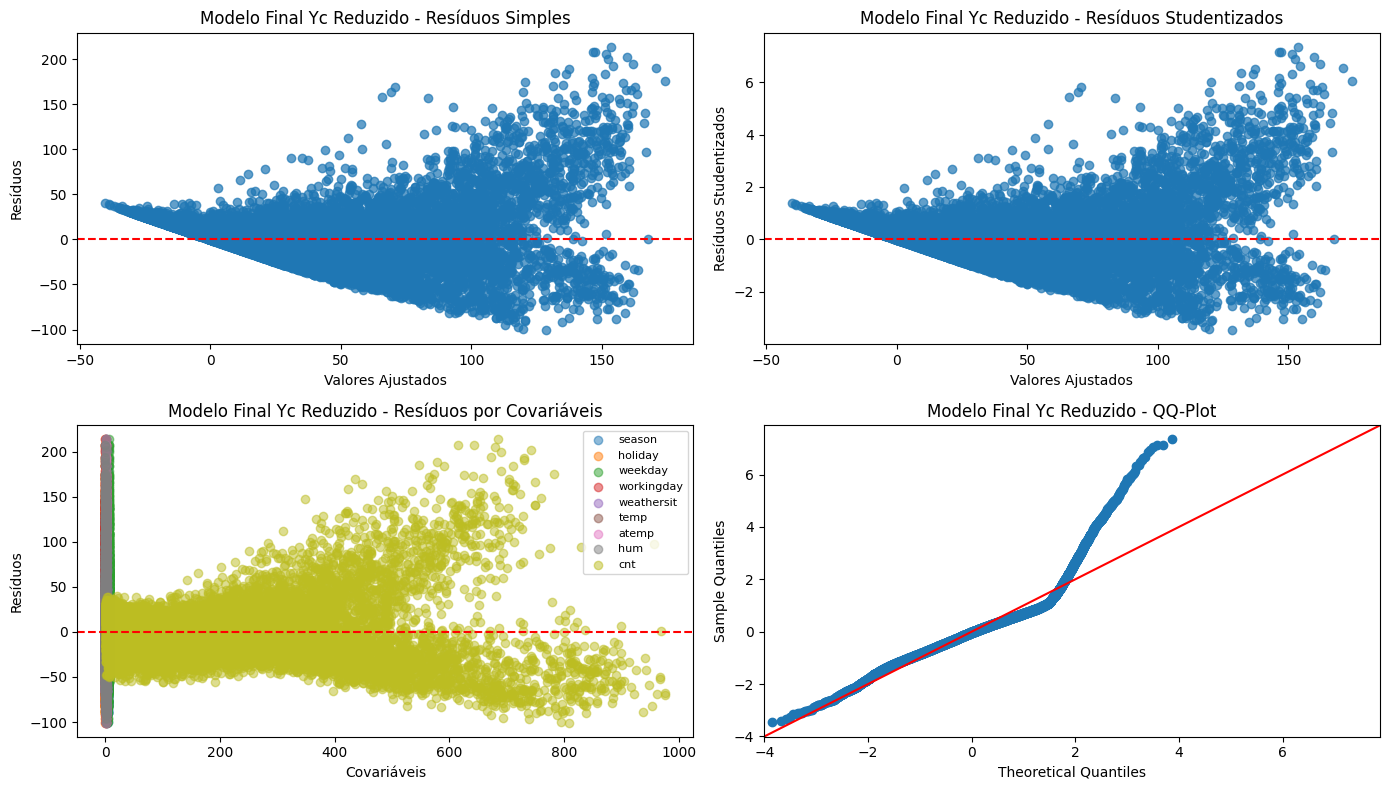


Gráfico de Observações Influentes para Yc (casual):


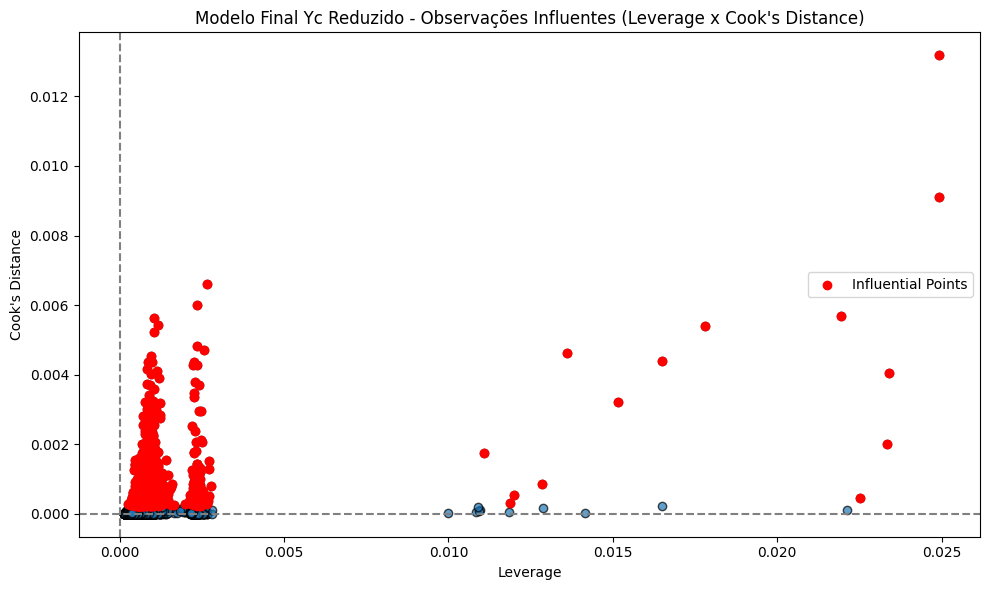

In [31]:
# Plotando para o modelo final reduzido de Yc
print("\nGráficos de Diagnóstico para Yc (casual):")
plot_diagnostics(final_model_Yc_reduced, X_reduced, Yc, "Modelo Final Yc Reduzido")

# Plotando para o modelo final reduzido de Yc
print("\nGráfico de Observações Influentes para Yc (casual):")
plot_influence_diagnostics(final_model_Yc_reduced, "Modelo Final Yc Reduzido")


Gráficos de Diagnóstico para Yr (registered):


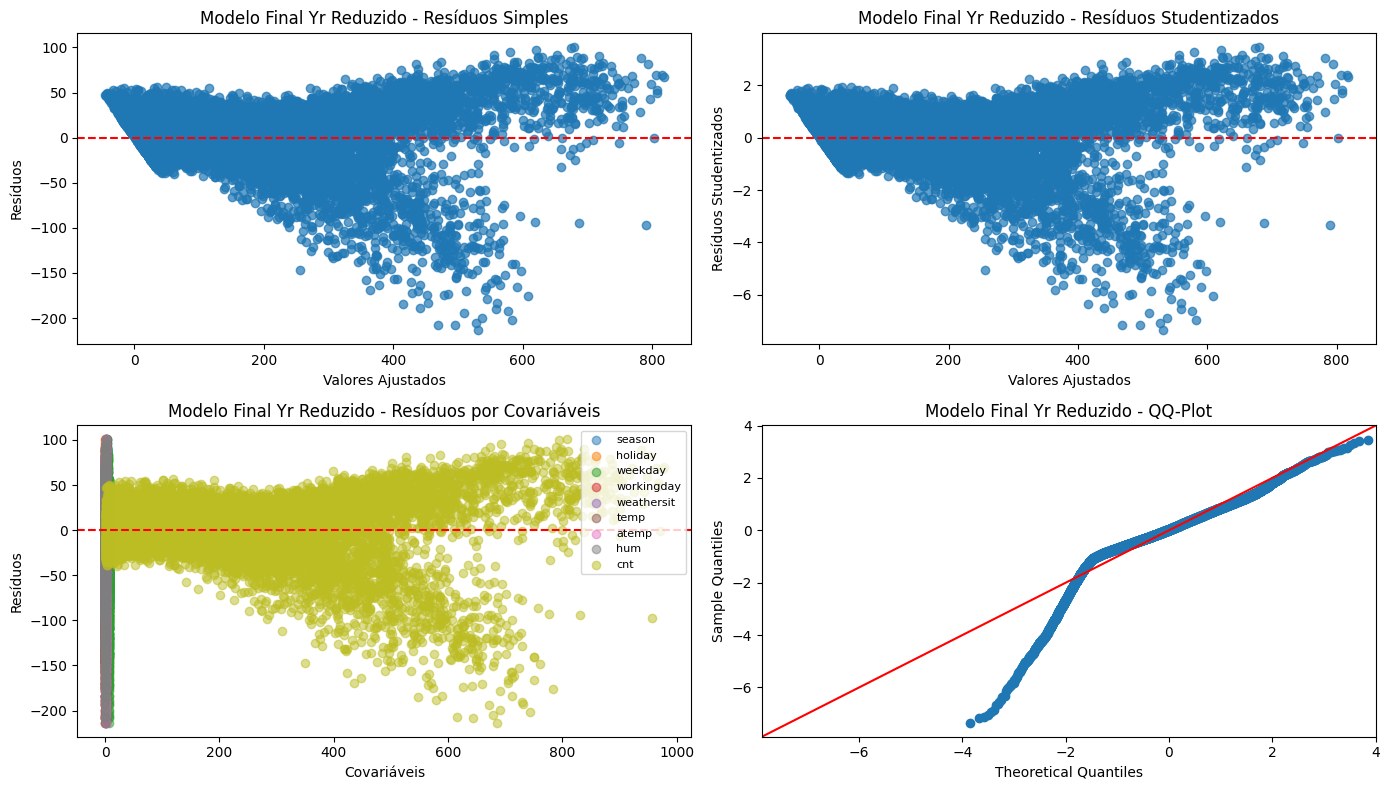


Gráfico de Observações Influentes para Yr (registered):


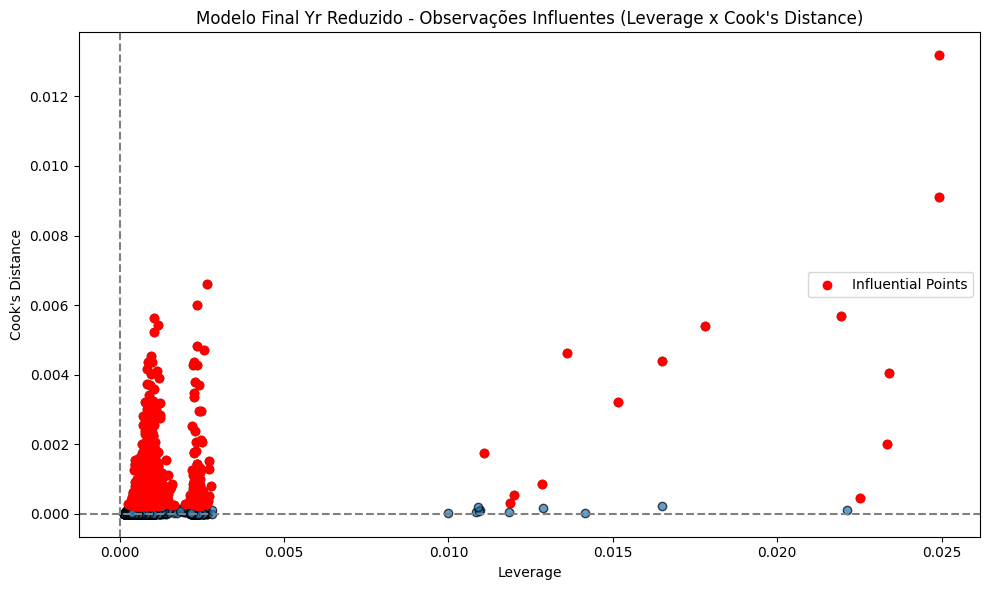

In [32]:
# Plotando para o modelo final reduzido de Yr
print("\nGráficos de Diagnóstico para Yr (registered):")
plot_diagnostics(final_model_Yr_reduced, X_reduced, Yr, "Modelo Final Yr Reduzido")

# Plotando para o modelo final reduzido de Yr
print("\nGráfico de Observações Influentes para Yr (registered):")
plot_influence_diagnostics(final_model_Yr_reduced, "Modelo Final Yr Reduzido")

#### Removendo observações influentes

In [33]:
def remove_influential_points(model, X, Y, threshold=4):
    # Obtendo os índices das observações influentes
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    threshold_cooks_d = threshold / len(X)  # Limite padrão para distância de Cook
    influential_points = np.where(cooks_d > threshold_cooks_d)[0]

    print(f"Número de observações influentes identificadas: {len(influential_points)}")
    print(f"Índices das observações influentes: {influential_points}")

    # Removendo observações influentes
    X_filtered = X.drop(index=influential_points)
    Y_filtered = Y.drop(index=influential_points)

    return X_filtered, Y_filtered


In [34]:
# Removendo observações influentes para Yc
X_reduced_Yc_filt, Yc_filt = remove_influential_points(
    final_model_Yc_reduced, X_reduced, Yc
)

# Removendo observações influentes para Yr
X_reduced_Yr_filt, Yr_filt = remove_influential_points(
    final_model_Yr_reduced, X_reduced, Yr
)

# Reajustando os modelos com os dados filtrados
final_model_Yc_filt = sm.OLS(Yc_filt, sm.add_constant(X_reduced_Yc_filt)).fit()
final_model_Yr_filt = sm.OLS(Yr_filt, sm.add_constant(X_reduced_Yr_filt)).fit()

# Exibindo os resumos dos novos modelos ajustados
print("\nResumo do modelo filtrado para Yc (casual):")
print(final_model_Yc_filt.summary())

print("\nResumo do modelo filtrado para Yr (registered):")
print(final_model_Yr_filt.summary())

Número de observações influentes identificadas: 1087
Índices das observações influentes: [ 1110  1111  1112 ... 17101 17223 17224]
Número de observações influentes identificadas: 1087
Índices das observações influentes: [ 1110  1111  1112 ... 17101 17223 17224]

Resumo do modelo filtrado para Yc (casual):
                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     4260.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:24:32   Log-Likelihood:                -70672.
No. Observations:               16292   AIC:                         1.414e+05
Df Residuals:                   16282   BIC:                         1.414e+05
Df Model:                           9                        

Note que a proporção com ma qual o modelo explica Yc e Yr aumentou. (observar $R^2$ nas saídas).
Também, note que agora a variável "weekday" já não é significativa, isso era espperado desde a análise descritiva, como há correlação entre ela e outras variáveis como "workday" não haverá perda teórica se removermos ela do modelo.

In [37]:
# Removendo a variável "weekday" dos dados filtrados
X_reduced_Yc_final = X_reduced_Yc_filt.drop(columns=["weekday"])
X_reduced_Yr_final = X_reduced_Yr_filt.drop(columns=["weekday"])

# Reajustando os modelos com a variável "weekday" removida
final_model_Yc_final = sm.OLS(Yc_filt, sm.add_constant(X_reduced_Yc_final)).fit()
final_model_Yr_final = sm.OLS(Yr_filt, sm.add_constant(X_reduced_Yr_final)).fit()

# Exibindo os resumos dos novos modelos ajustados sem a variável "weekday"
print("\nResumo do modelo filtrado para Yc (casual) sem a variável 'weekday':")
print(final_model_Yc_final.summary())

print("\nResumo do modelo filtrado para Yr (registered) sem a variável 'weekday':")
print(final_model_Yr_final.summary())



Resumo do modelo filtrado para Yc (casual) sem a variável 'weekday':
                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     4792.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:50:47   Log-Likelihood:                -70674.
No. Observations:               16292   AIC:                         1.414e+05
Df Residuals:                   16283   BIC:                         1.414e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------


Gráficos de Diagnóstico para Yc (casual):


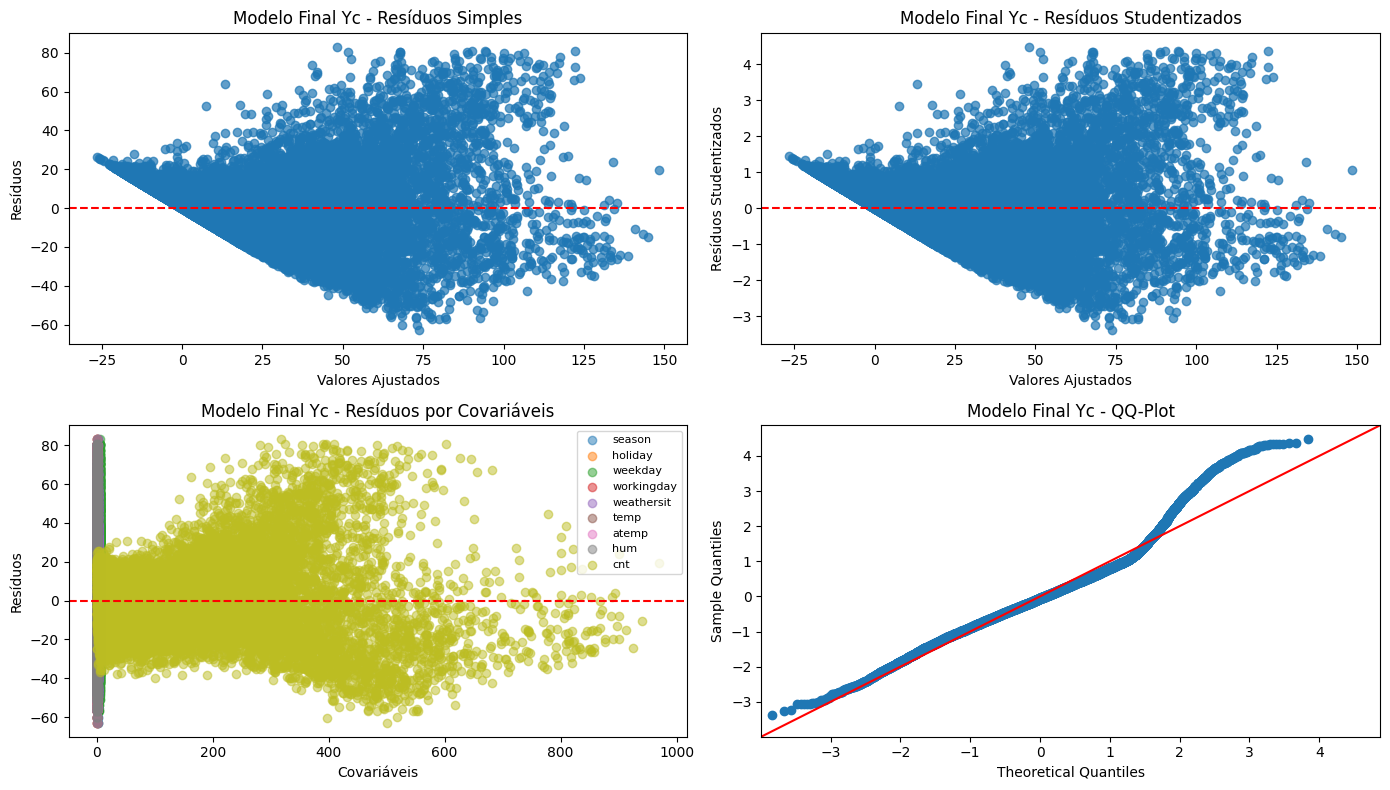


Gráfico de Observações Influentes para Yc (casual):


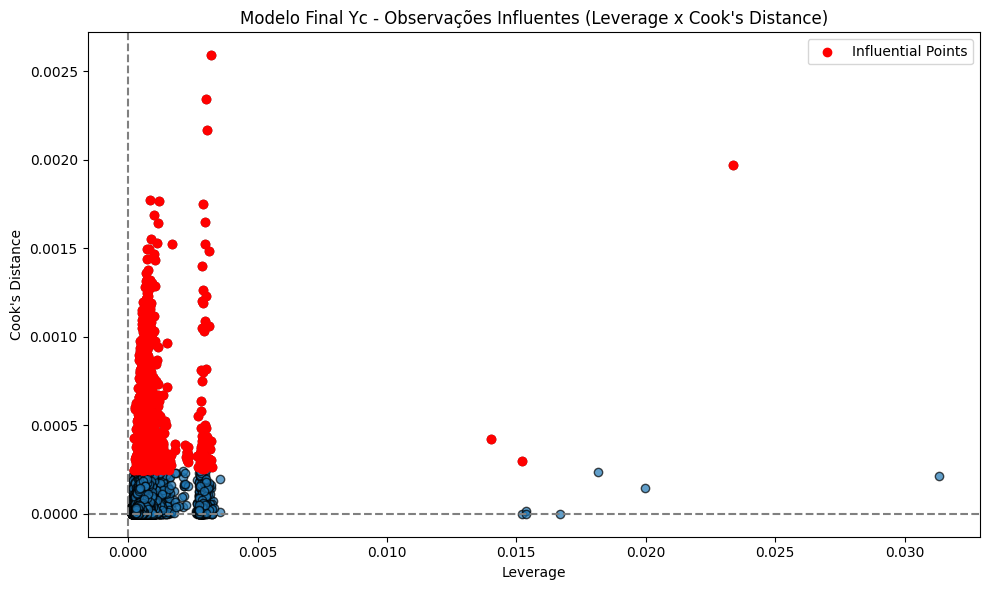

In [38]:
# Plotando para o modelo final reduzido de Yc
print("\nGráficos de Diagnóstico para Yc (casual):")
plot_diagnostics(final_model_Yc_final, X_reduced_Yc_filt, Yc, "Modelo Final Yc")

# Plotando para o modelo final reduzido de Yc
print("\nGráfico de Observações Influentes para Yc (casual):")
plot_influence_diagnostics(final_model_Yc_final, "Modelo Final Yc")


Gráficos de Diagnóstico para Yr (registered):


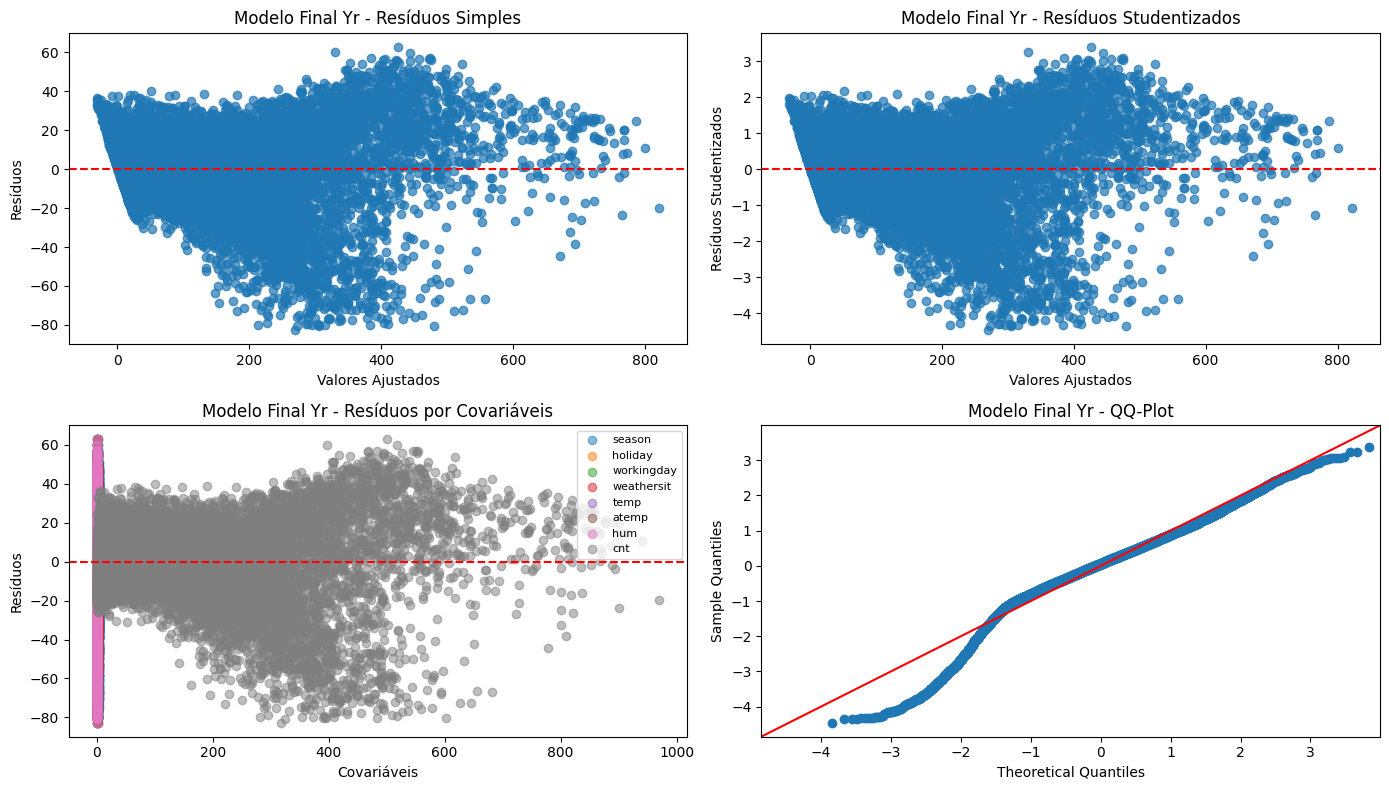


Gráfico de Observações Influentes para Yr (registered):


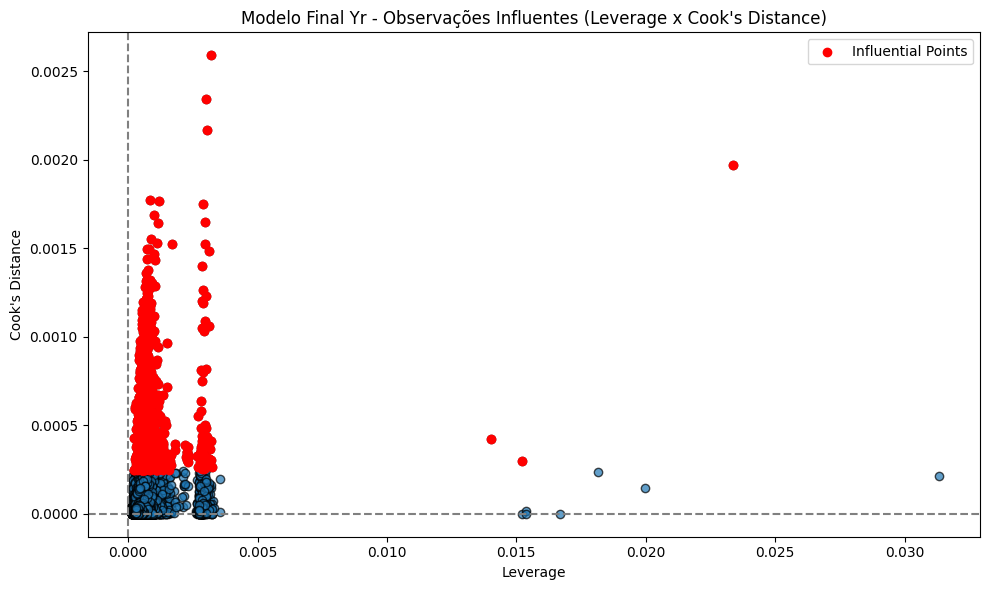

In [39]:
# Plotando para o modelo final reduzido de Yc
print("\nGráficos de Diagnóstico para Yr (registered):")
plot_diagnostics(final_model_Yr_filt, X_reduced_Yr_final, Yc, "Modelo Final Yr")

# Plotando para o modelo final reduzido de Yc
print("\nGráfico de Observações Influentes para Yr (registered):")
plot_influence_diagnostics(final_model_Yr_final, "Modelo Final Yr")

#### Conclusão

No fim, obtivemos 2 modelos bem ajustados, que descrevem a variabilidade dos dados adequadamente. Com boas métricas, como pode ser observado: $R^2c = 0.702$ e $R^2r = 0.980$, note também, que os critério AIC e BIC são melhores para esse modelos, comparados aos modelos anteriores.

Portanto, temos os modelos com base em apenas 8 variáveis, ou seja, nove parâmetros, não muito complexo, porém evidentemente eficaz.